In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.util import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
# Mount Google Drive ke Colab
drive.mount('/content/drive')

Mounted at /content/drive


Kolom yang ada: Index(['nomor', 'rev', 'sentiment'], dtype='object')

Jumlah data tiap sentimen:
sentiment
negatif     294
netral      426
positif    4881
Name: count, dtype: int64


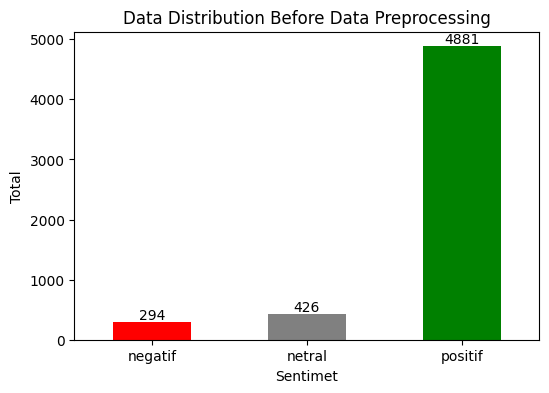

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load data ===
file = '/content/drive/My Drive/Data Research/Salinan data with sentiment.xlsx'
df_master = pd.read_excel(file)

# Cek nama kolom
print("Kolom yang ada:", df_master.columns)

# === 2. Hitung jumlah masing-masing sentimen ===
# Pastikan urutannya Negatif → Netral → Positif
sentiment_counts = df_master['sentiment'].value_counts().reindex(['negatif', 'netral', 'positif'])

print("\nJumlah data tiap sentimen:")
print(sentiment_counts)

# === 3. Plot grafik batang ===
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Data Distribution Before Data Preprocessing')
plt.xlabel('Sentimet')
plt.ylabel('Total')
plt.xticks(rotation=0)

# Tambahkan label di atas batang
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

# Simpan ke Google Drive
plt.savefig('/content/drive/My Drive/Data Research/Sentiment_Distribution_Before_Data_Preprocessing.png')

plt.show()


In [ ]:
print(df_master.columns)

Index(['nomor', 'rev', 'sentiment'], dtype='object')


In [ ]:
# Rename columns "rev" to "Review"
df_master.rename(columns={'rev': 'Review'}, inplace=True)
df_master.rename(columns={'sentiment': 'Sentiment'}, inplace=True)


df_master.head()

nomor                                             Review Sentiment
0      1  Sudah pernah pakai n langsung suka dibanding f...   positif
1      2  Saya suka dengan produk ini dan saya sangat se...   positif
2      3  KAHF Always be my favourite face wash wangi ny...   positif
3      4  Produk bagus banget. Ga bikin kering di muka, ...   positif
4      5  Kualitas produk sangat baik. Produk original. ...   positif

**Preprocessing**

1. Case Folding

In [ ]:
# Convert 'Review' columns to lowercase
df_master['Review'].str.lower()

# Display the DataFrame
df_master

nomor                                             Review Sentiment
0         1  Sudah pernah pakai n langsung suka dibanding f...   positif
1         2  Saya suka dengan produk ini dan saya sangat se...   positif
2         3  KAHF Always be my favourite face wash wangi ny...   positif
3         4  Produk bagus banget. Ga bikin kering di muka, ...   positif
4         5  Kualitas produk sangat baik. Produk original. ...   positif
...     ...                                                ...       ...
5596   5597  Kualitas wangi berkurang/makin menurun dari se...   negatif
5597   5598  Tidak wangi , sepertinya apakah yg di kirim in...   negatif
5598   5599                      cuma bertahan GX nyampe12 jam   negatif
5599   5600  sebenernya ga masalah sih, namanya bonus, tp K...   negatif
5600   5601  Saya tau kalau ini gratis, tapi setidaknya min...   negatif

[5601 rows x 3 columns]

2. Data Cleaning

In [ ]:
df_master['Review'].str.translate(str.maketrans('', '', string.punctuation))

0       Sudah pernah pakai n langsung suka dibanding f...
1       Saya suka dengan produk ini dan saya sangat se...
2       KAHF Always be my favourite face wash wangi ny...
3       Produk bagus banget Ga bikin kering di muka ba...
4       Kualitas produk sangat baik Produk original Ha...
                              ...                        
5596    Kualitas wangi berkurangmakin menurun dari seb...
5597    Tidak wangi  sepertinya apakah yg di kirim ini...
5598                        cuma bertahan GX nyampe12 jam
5599    sebenernya ga masalah sih namanya bonus tp Klo...
5600    Saya tau kalau ini gratis tapi setidaknya mini...
Name: Review, Length: 5601, dtype: object

In [ ]:
# Function to clean text
def clean_text(text):
    # Remove emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)

     # Remove usernames (assuming they start with '@')
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    # Remove special characters, hyperlinks, usernames, punctuation, numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove newline characters
    text = text.replace('\n', ' ')

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)               # Hapus karakter khusus dan emoji
    text = re.sub(r'[^\w\s@_]', '', text)                   # Ganti semua tanda baca dengan spasi
    text = re.sub(r'\d+', '', text)                         # Hapus semua angka
    text = re.sub(r'\s{2,}', ' ', text)                     # Hapus spasi ganda atau lebih, diganti dengan 1 spasi
    text = re.sub(r'(\w)\1{2,}', r'\1', text)               # Ganti huruf yang berulang sebanyak 3x atau lebih menjadi satu huruf
    text = re.sub(r'\n', '', text)                          # Hapus endline
    text = text.lower()                                     # Ubah menjadi huruf kecil (case folding)
    return text

# Apply the cleaning function to the 'Review Fitur' column
df_master['cleaned_text'] = df_master['Review'].apply(clean_text)

# Display the cleaned DataFrame
print(df_master[['cleaned_text']])

                                           cleaned_text
0     sudah pernah pakai n langsung suka dibanding f...
1     saya suka dengan produk ini dan saya sangat se...
2     kahf always be my favourite face wash wangi ny...
3     produk bagus banget ga bikin kering di muka ba...
4     kualitas produk sangat baik produk original ha...
...                                                 ...
5596  kualitas wangi berkurangmakin menurun dari seb...
5597  tidak wangi sepertinya apakah yg di kirim ini kw 
5598                        cuma bertahan gx nyampe jam
5599  sebenernya ga masalah sih namanya bonus tp klo...
5600  saya tau kalau ini gratis tapi setidaknya mini...

[5601 rows x 1 columns]


In [ ]:
df_master

nomor                                             Review Sentiment  \
0         1  Sudah pernah pakai n langsung suka dibanding f...   positif   
1         2  Saya suka dengan produk ini dan saya sangat se...   positif   
2         3  KAHF Always be my favourite face wash wangi ny...   positif   
3         4  Produk bagus banget. Ga bikin kering di muka, ...   positif   
4         5  Kualitas produk sangat baik. Produk original. ...   positif   
...     ...                                                ...       ...   
5596   5597  Kualitas wangi berkurang/makin menurun dari se...   negatif   
5597   5598  Tidak wangi , sepertinya apakah yg di kirim in...   negatif   
5598   5599                      cuma bertahan GX nyampe12 jam   negatif   
5599   5600  sebenernya ga masalah sih, namanya bonus, tp K...   negatif   
5600   5601  Saya tau kalau ini gratis, tapi setidaknya min...   negatif   

                                           cleaned_text  
0     sudah pernah pakai n langsung suka dibanding f...  
1     saya suka dengan produk ini dan saya sangat se...  
2     kahf always be my favourite face wash wangi ny...  
3     produk bagus banget ga bikin kering di muka ba...  
4     kualitas produk sangat baik produk original ha...  
...                                                 ...  
5596  kualitas wangi berkurangmakin menurun dari seb...  
5597  tidak wangi sepertinya apakah yg di kirim ini kw   
5598                        cuma bertahan gx nyampe jam  
5599  sebenernya ga masalah sih namanya bonus tp klo...  
5600  saya tau kalau ini gratis tapi setidaknya mini...  

[5601 rows x 4 columns]

3. Filtering

In [ ]:
nltk.download('stopwords')
english_s = stopwords.words('english')
indonesia_s = stopwords.words('indonesian')
stop_words = set(indonesia_s)
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ambil stopwords bahasa Indonesia
indonesia_stopwords = set(stopwords.words('indonesian'))

# Daftar kata penting yang harus dipertahankan
critical_words = {'tidak', 'bukan', 'belum', 'kurang', 'hanya'}

# Buat stopword list final, dengan menghapus kata penting
custom_stopwords = indonesia_stopwords - critical_words

# Tokenisasi
df_master['tokens'] = df_master['cleaned_text'].apply(word_tokenize)

# Filter stopwords (tanpa menghapus kata penting)
df_master['filtered_tokens'] = df_master['tokens'].apply(
    lambda x: [word for word in x if word.lower() not in custom_stopwords]
)

# Gabungkan kembali token menjadi kalimat
df_master['final_cleaned_text'] = df_master['filtered_tokens'].apply(lambda x: ' '.join(x))

# Lihat hasilnya
print(df_master[['final_cleaned_text']].head())

                                  final_cleaned_text
0  pakai n langsung suka dibanding face wash yg a...
1  suka produk seneng beli pengiriman cepat cocok...
2  kahf always be my favourite face wash wangi ny...
3  produk bagus banget ga bikin kering muka bauny...
4  kualitas produk produk original harga produk k...


In [ ]:
df_master['final_cleaned_text']

0       pakai n langsung suka dibanding face wash yg a...
1       suka produk seneng beli pengiriman cepat cocok...
2       kahf always be my favourite face wash wangi ny...
3       produk bagus banget ga bikin kering muka bauny...
4       kualitas produk produk original harga produk k...
                              ...                        
5596            kualitas wangi berkurangmakin menurun edp
5597                              tidak wangi yg kirim kw
5598                               bertahan gx nyampe jam
5599    sebenernya ga sih namanya bonus tp klo sesuai ...
5600         tau gratis minimal barangnya gambar berharap
Name: final_cleaned_text, Length: 5601, dtype: object

In [ ]:
ref = pd.read_excel('/content/drive/My Drive/Data Research/slangword by pujangga.xlsx')
# data preparation
ref_dict = dict(zip(ref['sebelum'], ref['sesudah']))
def replace_text(text, ref_dict):
    words = text.split()
    words = [ref_dict[word] if word in ref_dict else word for word in words]
    return ' '.join(words)

df_master['Slang_removed'] = df_master['final_cleaned_text'].apply(replace_text, ref_dict=ref_dict)

In [ ]:
from nltk.corpus import stopwords
# Stopwords dasar bahasa Indonesia
indonesian_stopwords = set(stopwords.words('indonesian'))

# Kata penting yang tidak boleh dihapus
critical_words = {'tidak', 'bukan', 'belum', 'kurang', 'hanya'}

# Final stopwords
custom_stopwords = indonesian_stopwords - critical_words

def remove_stopwords(text):
    words = text.split()
    # Filter: buang stopwords, buang kata pendek (<5), tapi tetap simpan 'yang'
    filtered = [word for word in words if (word not in custom_stopwords and len(word) > 4) or word == 'yang']
    return ' '.join(filtered)

df_master['Filtered'] = df_master['Slang_removed'].apply(remove_stopwords)

In [ ]:
# Tahap : Hapus semua kata yang hanya mengandung 3 huruf
def remove_short_words(text):
    words = text.split()
    words = [word for word in words if len(word) > 4 or word == 'yang']
    return ' '.join(words)

df_master['Filtered_1st'] = df_master['Filtered'].apply(remove_short_words)

In [ ]:
df_master['Filtered_1st']

0       pakai langsung dibanding yang aroma sabunnya s...
1       produk seneng pengiriman cepat cocok wajah ter...
2       always favourite wangi banget teksturnya halus...
3       produk bagus banget tidak bikin kering wajah b...
4       kualitas produk produk original harga produk k...
                              ...                        
5596                kualitas wangi berkurangmakin menurun
5597                       tidak wangi yang kirim imitasi
5598                                             bertahan
5599    sebenernya tidak namanya bonus sesuai gambar o...
5600             gratis minimal barangnya gambar berharap
Name: Filtered_1st, Length: 5601, dtype: object

In [ ]:
df_master['Filtered_1st'].to_excel('/content/drive/My Drive/Data Research/Filtering.xlsx', index=False)

4. Stemming

In [ ]:
# Tahap 6: Lakukan stemming dari library Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    words = text.split()
    stemmed_words = []
    for word in words:
        if word == 'emas':
            stemmed_words.append(word)
        elif 'emas' in word and word != 'emas':
            stemmed_words.append(word)  # jangan stem jika ada 'emas' di dalamnya, tapi bukan 'emas' saja
        else:
            stemmed_words.append(stemmer.stem(word))
    return ' '.join(stemmed_words)

df_master['Stemmed_Text'] = df_master['Filtered_1st'].apply(stem_text)
df_master_to_save = df_master[['Stemmed_Text', 'Sentiment']].rename(columns={'Stemmed_Text': 'Review'})
df_master_to_save.to_excel('/content/drive/My Drive/Data Research/Stemming.xlsx', index=False)

5. Tokenizing Unigram

In [ ]:
import pandas as pd
from nltk.corpus import stopwords

# Set stopwords bahasa Indonesia dari NLTK
stop_words = set(stopwords.words('indonesian'))

# Kata-kata penting yang tidak boleh dihapus meskipun termasuk stopword
critical_words = {'tidak', 'bukan', 'belum', 'kurang', 'hanya'}

# Fungsi untuk menghapus stopwords, tapi mempertahankan kata penting
def remove_stopwords(text):
    if pd.isnull(text):
        return ''
    words = text.split()
    filtered = [word for word in words if word not in stop_words or word in critical_words]
    return ' '.join(filtered).strip()

# Terapkan pembersihan stopwords ke kolom Stemmed_Text
df_master['Filtered_2sd'] = df_master['Stemmed_Text'].apply(remove_stopwords)

# Hapus baris yang kosong di Filtered_2sd (setelah stopword removal)
df_master = df_master[df_master['Filtered_2sd'].str.strip() != '']

# Buat salinan bersih untuk disimpan
final_clean_text = df_master[['Filtered_2sd', 'Sentiment']].rename(columns={'Filtered_2sd': 'Review'})

# Simpan ke Excel
final_clean_text.to_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx', index=False)


In [ ]:

# Tahap 8: Lakukan tokenizing unigram
def create_unigrams(text):
    words = text.split()
    unigrams = ngrams(words, 1)
    return ', '.join([' '.join(unigram) for unigram in unigrams])

df_master['Unigrams'] = df_master['Filtered_2sd'].apply(create_unigrams)
df_master['Unigrams'].to_excel('/content/drive/My Drive/Data Research/Unigram_Tokenizing.xlsx', index=False)

/tmp/ipython-input-21-2798071667.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master['Unigrams'] = df_master['Filtered_2sd'].apply(create_unigrams)


**WordCloud**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


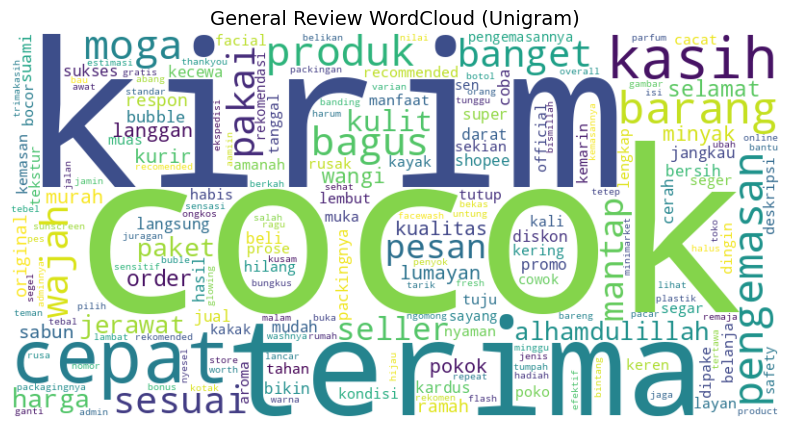

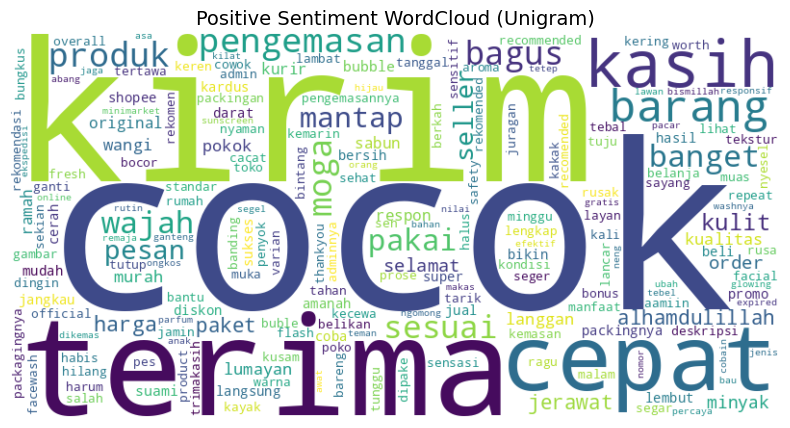

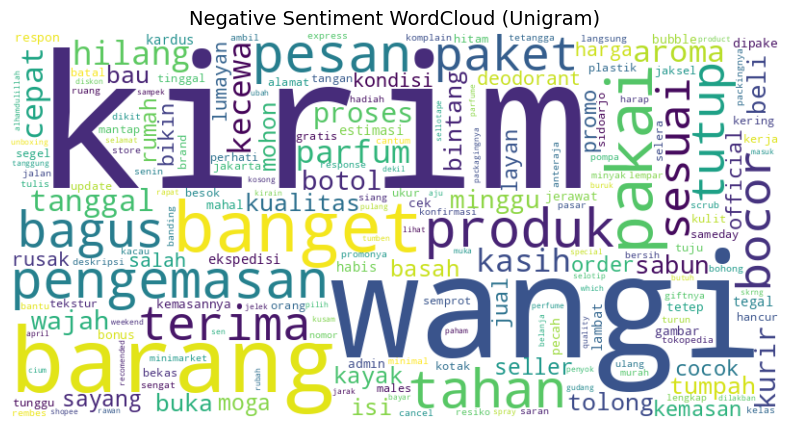

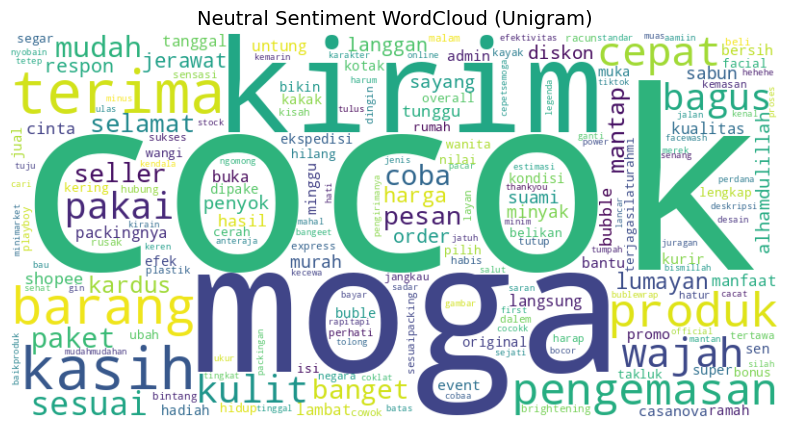

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
import nltk

# Unduh stopwords bahasa Indonesia (jika belum)
nltk.download('stopwords')

# === 1. Baca dan Siapkan Data ===
hybridteaching = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# Pastikan kolom 'Review' berupa string
hybridteaching = hybridteaching.dropna(subset=['Review'])
hybridteaching['Review'] = hybridteaching['Review'].astype(str)

# === 2. Stopwords Bahasa Indonesia ===
stopwords_indonesia = set(stopwords.words('indonesian'))

# === 3. Fungsi Membuat WordCloud Unigram ===
def generate_unigram_wordcloud(df, title, filepath):
    # Tokenisasi menjadi unigram
    all_unigrams = [unigram for tokens in df['Review'] for unigram in ngrams(tokens.split(), 1)]
    unigram_text = [' '.join(unigram) for unigram in all_unigrams]

    # Gabungkan semua unigram jadi satu string
    text = ' '.join(unigram_text)

    # Buat WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords_indonesia,
        collocations=False
    ).generate(text)

    # Tampilkan
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

    # Simpan ke file
    wordcloud.to_file(filepath)

# === 4. Buat WordCloud Berdasarkan Sentimen ===

# General (semua review)
generate_unigram_wordcloud(
    hybridteaching,
    'General Review WordCloud (Unigram)',
    '/content/drive/My Drive/Data Research/General_Review_WordCloud_Unigram.png'
)

# Positif
generate_unigram_wordcloud(
    hybridteaching[hybridteaching['Sentiment'].str.lower() == 'positif'],
    'Positive Sentiment WordCloud (Unigram)',
    '/content/drive/My Drive/Data Research/Positive_Sentiment_WordCloud_Unigram.png'
)

# Negatif
generate_unigram_wordcloud(
    hybridteaching[hybridteaching['Sentiment'].str.lower() == 'negatif'],
    'Negative Sentiment WordCloud (Unigram)',
    '/content/drive/My Drive/Data Research/Negative_Sentiment_WordCloud_Unigram.png'
)

# Netral
generate_unigram_wordcloud(
    hybridteaching[hybridteaching['Sentiment'].str.lower() == 'netral'],
    'Neutral Sentiment WordCloud (Unigram)',
    '/content/drive/My Drive/Data Research/Neutral_Sentiment_WordCloud_Unigram.png'
)


**Pembobotan TF-IDF**

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

In [ ]:
# Assuming youtube is a DataFrame with a 'Review' column
# Replace this with your actual data loading process
hybridteaching = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# Convert 'Review' column to strings and remove NaN or non-string values
hybridteaching['Review'] = hybridteaching['Review'].astype(str)

# Define stopwords Bahasa Indonesia from NLTK
stopwords_indonesia = set(nltk.corpus.stopwords.words('indonesian'))

# Create a TfidfVectorizer with bigram and Indonesian stopwords
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_indonesia), ngram_range=(1,1), max_features=5000)  # Adjust parameters as needed

# Fit and transform the 'Reviews' column
tfidf_matrix = tfidf_vectorizer.fit_transform(hybridteaching['Review'])

# Get feature names (words) and TF-IDF values
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# Create a DataFrame to display the results
tfidf_df = pd.DataFrame(data=tfidf_values, columns=feature_names)

# Save TF-IDF DataFrame to a CSV file
tfidf_df.to_csv('/content/drive/My Drive/Data Research/tfidf_results_unigram.xlsx', index=False)
# Display the TF-IDF DataFrame
print(tfidf_df)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


      aalaamiin  aamiin  aamiinkalo  aamiinlah  aamiinmakasiih  \
0           0.0     0.0         0.0        0.0             0.0   
1           0.0     0.0         0.0        0.0             0.0   
2           0.0     0.0         0.0        0.0             0.0   
3           0.0     0.0         0.0        0.0             0.0   
4           0.0     0.0         0.0        0.0             0.0   
...         ...     ...         ...        ...             ...   
5490        0.0     0.0         0.0        0.0             0.0   
5491        0.0     0.0         0.0        0.0             0.0   
5492        0.0     0.0         0.0        0.0             0.0   
5493        0.0     0.0         0.0        0.0             0.0   
5494        0.0     0.0         0.0        0.0             0.0   

      aamiinyaarabbalaalamiin  aamin  abalga  abang  abangkuh  ...  yaterima  \
0                         0.0    0.0     0.0    0.0       0.0  ...       0.0   
1                         0.0    0.0     0.0   

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import nltk

# Download stopwords jika belum
nltk.download('stopwords')

# Load dataset
df = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# Pastikan kolom Review berupa string dan tidak kosong
df = df[df['Review'].notna()]
df['Review'] = df['Review'].astype(str)
df = df[df['Review'].str.strip() != '']

# Stopwords bahasa Indonesia
stopwords_indonesia = set(stopwords.words('indonesian'))

# Kata penting yang harus dipertahankan
critical_words = {'tidak', 'bukan', 'belum', 'kurang', 'hanya'}

# Final stopwords untuk analisis sentimen
custom_stopwords = stopwords_indonesia - critical_words

# Fungsi untuk mendapatkan top bigram
def get_top_bigram(dataframe, label=None):
    if label:
        dataframe = dataframe[dataframe['Sentiment'].str.lower() == label.lower()]

    all_bigrams = [bigram for tokens in dataframe['Review'] for bigram in ngrams(tokens.split(), 2)]

    # Filter stopwords dari kedua kata dalam bigram
    filtered_bigrams = [
        bigram for bigram in all_bigrams
        if all(word.lower() not in custom_stopwords for word in bigram)
    ]

    bigram_freq = Counter(filtered_bigrams)
    return bigram_freq.most_common(20)

# 1. General (semua data)
print("=== 🔍 Top Bigram (General) ===")
for bigram, freq in get_top_bigram(df):
    print(f"{' '.join(bigram)}: {freq}")

# 2. Positif
print("\n=== ✅ Top Bigram (Positif) ===")
for bigram, freq in get_top_bigram(df, 'positif'):
    print(f"{' '.join(bigram)}: {freq}")

# 3. Negatif
print("\n=== ❌ Top Bigram (Negatif) ===")
for bigram, freq in get_top_bigram(df, 'negatif'):
    print(f"{' '.join(bigram)}: {freq}")

# 4. Netral
print("\n=== ⚪ Top Bigram (Netral) ===")
for bigram, freq in get_top_bigram(df, 'netral'):
    print(f"{' '.join(bigram)}: {freq}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== 🔍 Top Bigram (General) ===
terima kasih: 1155
kirim cepat: 770
moga cocok: 624
sesuai pesan: 331
kasih seller: 291
barang sesuai: 227
cocok kulit: 221
cocok wajah: 148
cepat pengemasan: 145
pengemasan kirim: 122
cocok pakai: 115
kulit wajah: 110
produk bagus: 103
cepat terima: 92
barang selamat: 92
cepat banget: 91
barang terima: 84
bagus banget: 83
produk original: 81
sabun wajah: 80

=== ✅ Top Bigram (Positif) ===
terima kasih: 1077
kirim cepat: 739
moga cocok: 514
sesuai pesan: 323
kasih seller: 279
barang sesuai: 216
cocok kulit: 194
cepat pengemasan: 137
cocok wajah: 133
pengemasan kirim: 119
cocok pakai: 106
kulit wajah: 95
produk bagus: 90
cepat terima: 90
cepat banget: 87
bagus banget: 82
barang selamat: 82
produk original: 79
barang terima: 76
kualitas produk: 74

=== ❌ Top Bigram (Negatif) ===
wangi tidak: 12
terima kasih: 10
tidak sesuai: 9
tidak tahan: 9
kirim banget: 7
tahan wangi: 6
kirim pakai: 5
wangi kurang: 5
cepat hilang: 5
tutup tidak: 5
produk bagus: 4
barang k

**Pelabelan NLTK**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming hybridteaching is a DataFrame with a 'Review' column
# Replace this with your actual data loading process
hybridteaching = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')
hybridteaching.dtypes


Review       object
Sentiment    object
dtype: object

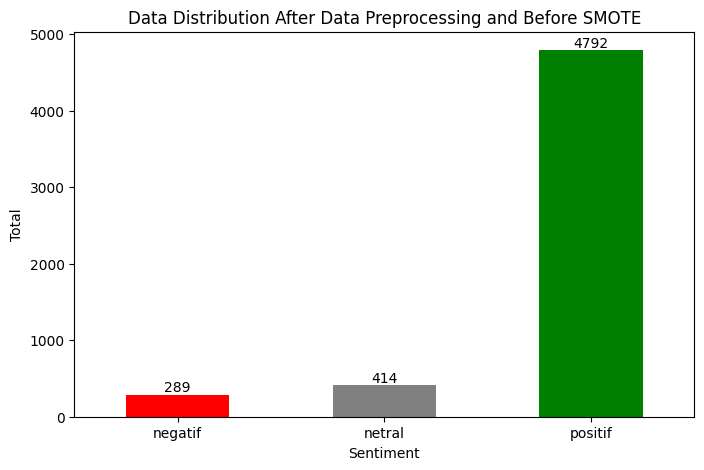

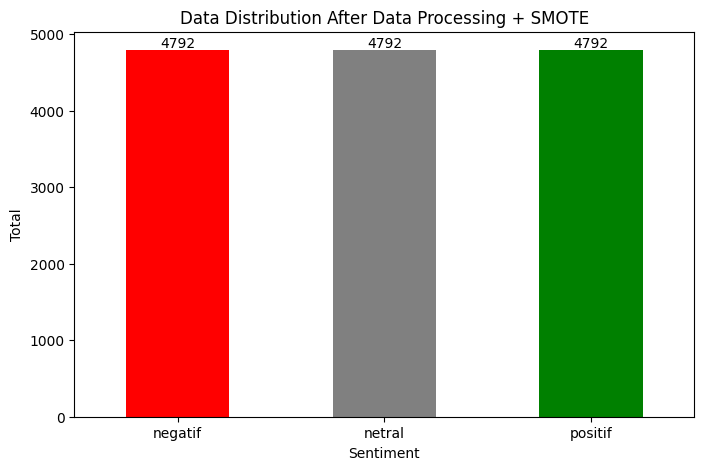

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# === 1. Load data ===
hybridteaching = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# === 2. Hitung distribusi sebelum SMOTE ===
sentiment_counts = hybridteaching['Sentiment'].value_counts().sort_index()

# === 3. SMOTE ===
# Separate features (X) and target (y)
X = hybridteaching['Review']
y = hybridteaching['Sentiment']

# Convert text data to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Create DataFrame for visualization
hybridteaching_resampled = pd.DataFrame(X_resampled.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
hybridteaching_resampled['Sentiment'] = y_resampled

# Hitung distribusi setelah SMOTE
sentiment_counts_smote = hybridteaching_resampled['Sentiment'].value_counts().sort_index()

# === 4. Plot sebelum SMOTE ===
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['Red', 'Gray', 'Green'])
plt.title('Data Distribution After Data Preprocessing and Before SMOTE')
plt.xlabel('Sentiment')
plt.ylabel('Total')
plt.xticks(rotation=0)
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
plt.savefig('/content/drive/My Drive/Data Research/Sentiment_Bar_Chart_Before_SMOTE.png')
plt.show()

# === 5. Plot setelah SMOTE ===
plt.figure(figsize=(8, 5))
sentiment_counts_smote.plot(kind='bar', color=['Red', 'Gray', 'Green'])
plt.title('Data Distribution After Data Processing + SMOTE')
plt.xlabel('Sentiment')
plt.ylabel('Total')
plt.xticks(rotation=0)
for i, count in enumerate(sentiment_counts_smote):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
plt.savefig('/content/drive/My Drive/Data Research/Sentiment_Bar_Chart_After_SMOTE.png')
plt.show()


**KNN**

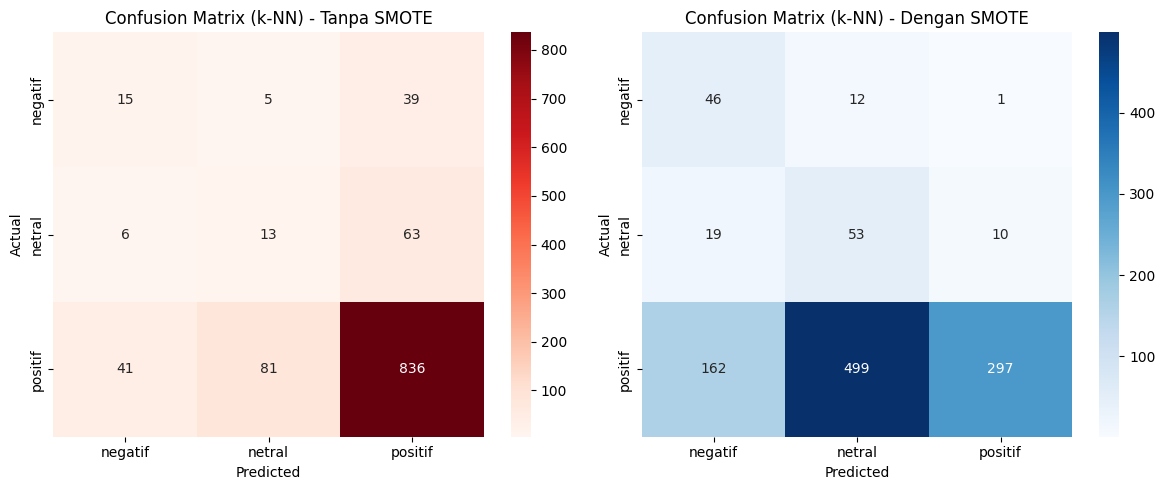

         Metode   Accuracy  CV Accuracy  Precision     Recall   F1-score  \
0   Tanpa SMOTE  78.616924    74.000104  42.150220  42.847508  42.447894   
1  Dengan SMOTE  36.032757    72.083156  42.030017  57.867445  31.831977   

                               Confusion Matrix  
0     [[15, 5, 39], [6, 13, 63], [41, 81, 836]]  
1  [[46, 12, 1], [19, 53, 10], [162, 499, 297]]  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# 2. Pisahkan fitur dan label
X = df['Review']
y = df['Sentiment']

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 5. Inisialisasi model k-NN
knn = KNeighborsClassifier(n_neighbors=3)

##########################################
# A. Tanpa SMOTE
##########################################
knn.fit(X_train_tfidf, y_train)
y_pred_no_smote = knn.predict(X_test_tfidf)

accuracy_no = accuracy_score(y_test, y_pred_no_smote) * 100
precision_no = precision_score(y_test, y_pred_no_smote, average='macro', zero_division=0) * 100
recall_no = recall_score(y_test, y_pred_no_smote, average='macro', zero_division=0) * 100
f1_no = f1_score(y_test, y_pred_no_smote, average='macro') * 100
cm_no = confusion_matrix(y_test, y_pred_no_smote)

##########################################
# B. Dengan SMOTE
##########################################
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

knn.fit(X_train_smote, y_train_smote)
y_pred_smote = knn.predict(X_test_tfidf)

accuracy_sm = accuracy_score(y_test, y_pred_smote) * 100
precision_sm = precision_score(y_test, y_pred_smote, average='macro', zero_division=0) * 100
recall_sm = recall_score(y_test, y_pred_smote, average='macro', zero_division=0) * 100
f1_sm = f1_score(y_test, y_pred_smote, average='macro') * 100
cm_sm = confusion_matrix(y_test, y_pred_smote)

##########################################
# C. Visualisasi Confusion Matrix
##########################################
labels = ['negatif', 'netral', 'positif']

# Tanpa SMOTE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_no, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (k-NN) - Tanpa SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Dengan SMOTE
plt.subplot(1, 2, 2)
sns.heatmap(cm_sm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (k-NN) - Dengan SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

##########################################
# D. Tampilkan hasil evaluasi
##########################################
result = pd.DataFrame({
    'Metode': ['Tanpa SMOTE', 'Dengan SMOTE'],
    'Accuracy': [accuracy_no, accuracy_sm],
    'CV Accuracy': [cross_val_score(knn, X_train_tfidf, y_train, cv=10).mean() * 100,
                    cross_val_score(knn, X_train_smote, y_train_smote, cv=10).mean() * 100],
    'Precision': [precision_no, precision_sm],
    'Recall': [recall_no, recall_sm],
    'F1-score': [f1_no, f1_sm],
    'Confusion Matrix': [cm_no, cm_sm]
})

print(result)

**NAIVE BAYES**

               Accuracy  CV Accuracy  Precision     Recall   F1 Score  \
Tanpa SMOTE   87.170155    87.261182  75.986359  87.170155  81.194952   
Dengan SMOTE  81.255687    89.854161  87.281814  81.255687  83.617393   

                      Confussion Matrix Tanpa SMOTE  \
Tanpa SMOTE   [[0, 0, 59], [0, 0, 82], [0, 0, 958]]   
Dengan SMOTE                                    NaN   

                          Confussion Matrix Dengan SMOTE  
Tanpa SMOTE                                          NaN  
Dengan SMOTE  [[52, 1, 6], [12, 32, 38], [27, 122, 809]]  


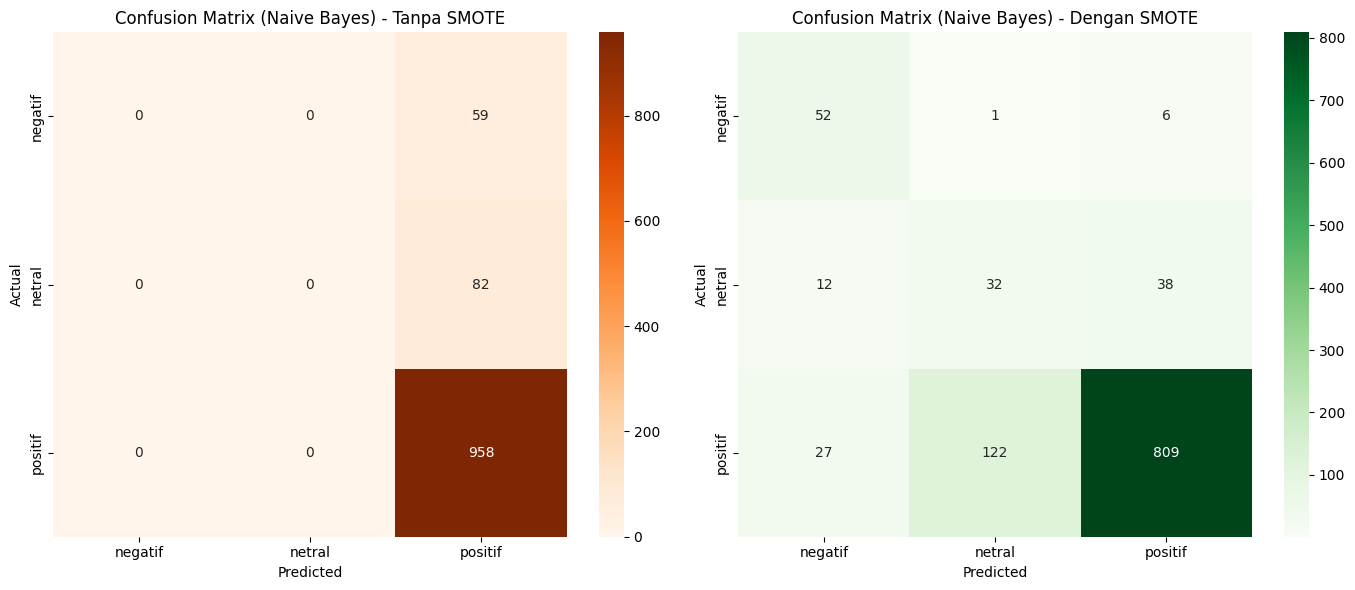

In [ ]:
# Import library
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Baca dataset
df = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# 2. Pisahkan fitur dan label
X = df['Review']
y = df['Sentiment']

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Inisialisasi model
nb_model_no_smote = MultinomialNB()
nb_model_smote = MultinomialNB()

### === TANPA SMOTE ===
nb_model_no_smote.fit(X_train_tfidf, y_train)
y_pred_no_smote = nb_model_no_smote.predict(X_test_tfidf)
cv_no_smote = cross_val_score(nb_model_no_smote, X_train_tfidf, y_train, cv=10).mean() * 100
cm_no_smote = confusion_matrix(y_test, y_pred_no_smote)

# Evaluasi Tanpa SMOTE
metrics_no_smote = {
    'Accuracy': accuracy_score(y_test, y_pred_no_smote) * 100,
    'CV Accuracy': cv_no_smote,
    'Precision': precision_score(y_test, y_pred_no_smote, average='weighted', zero_division=0) * 100,
    'Recall': recall_score(y_test, y_pred_no_smote, average='weighted', zero_division=0) * 100,
    'F1 Score': f1_score(y_test, y_pred_no_smote, average='weighted', zero_division=0) * 100,
    'Confussion Matrix Tanpa SMOTE': cm_no_smote
}

### === DENGAN SMOTE ===
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

nb_model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = nb_model_smote.predict(X_test_tfidf)
cv_smote = cross_val_score(nb_model_smote, X_train_smote, y_train_smote, cv=10).mean() * 100
cm_smote = confusion_matrix(y_test, y_pred_smote)

# Evaluasi Dengan SMOTE
metrics_smote = {
    'Accuracy': accuracy_score(y_test, y_pred_smote) * 100,
    'CV Accuracy': cv_smote,
    'Precision': precision_score(y_test, y_pred_smote, average='weighted', zero_division=0) * 100,
    'Recall': recall_score(y_test, y_pred_smote, average='weighted', zero_division=0) * 100,
    'F1 Score': f1_score(y_test, y_pred_smote, average='weighted', zero_division=0) * 100,
    'Confussion Matrix Dengan SMOTE': cm_smote
}

# Gabungkan hasil evaluasi
comparison_df = pd.DataFrame([metrics_no_smote, metrics_smote], index=['Tanpa SMOTE', 'Dengan SMOTE'])
print(comparison_df)

# Visualisasi Confusion Matrix
labels = ['negatif', 'netral', 'positif']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_no_smote, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Confusion Matrix (Naive Bayes) - Tanpa SMOTE')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Confusion Matrix (Naive Bayes) - Dengan SMOTE')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


**SVM**

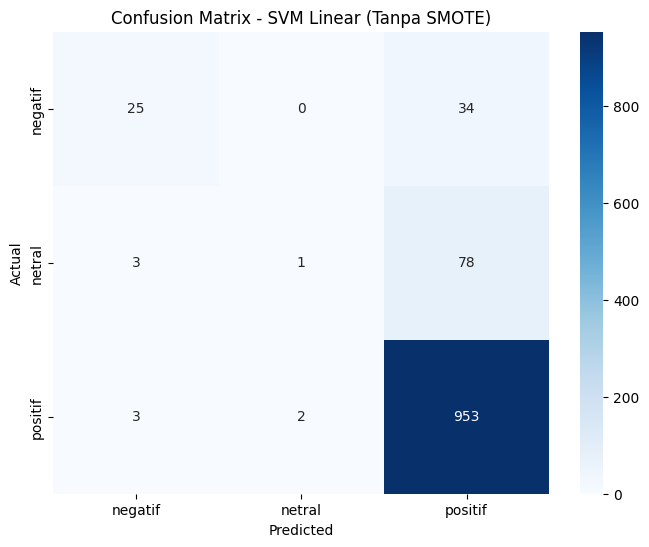

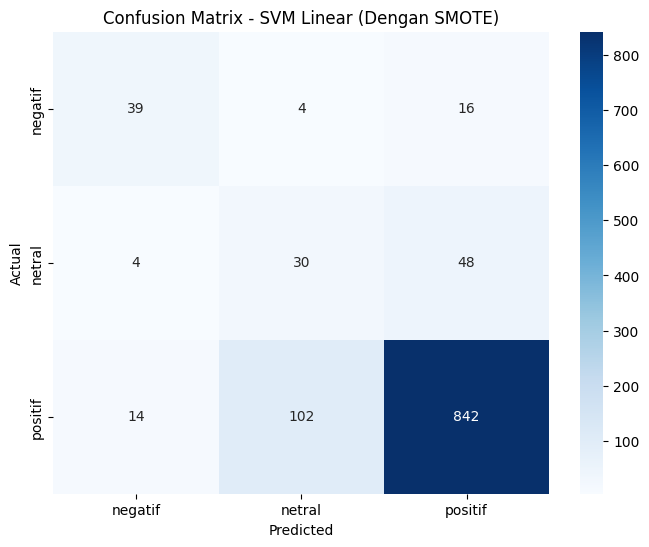

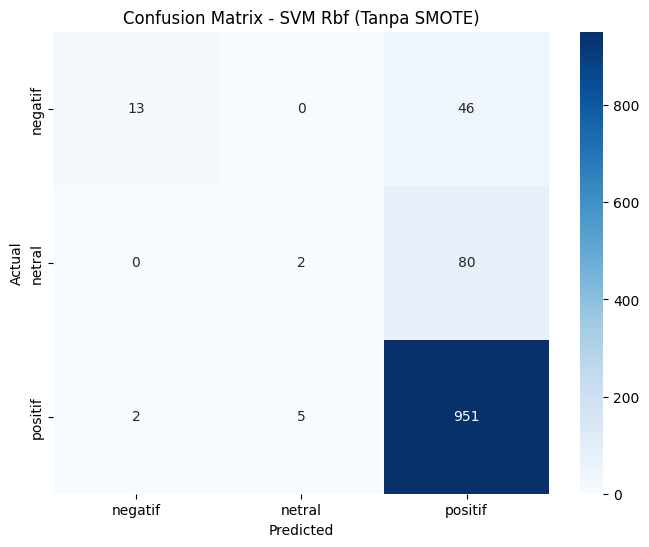

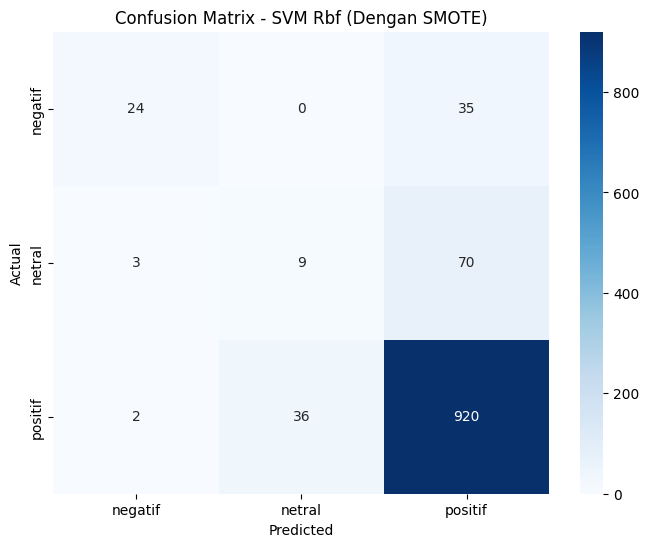

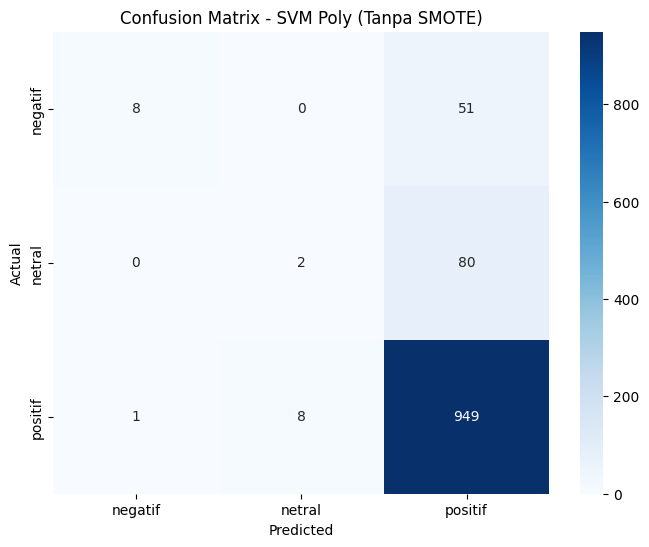

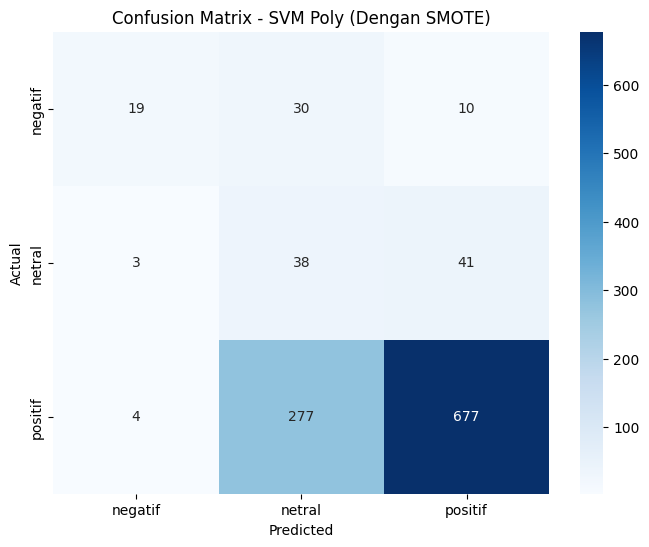

        Model         SMOTE   Accuracy  CV Accuracy  Precision     Recall  \
0  SVM Linear   Tanpa SMOTE  89.080983    88.102713  84.819523  89.080983   
1  SVM Linear  Dengan SMOTE  82.893540    91.097284  86.331517  82.893540   
2     SVM Rbf   Tanpa SMOTE  87.898089    87.761286  83.756498  87.898089   
3     SVM Rbf  Dengan SMOTE  86.715196    96.896544  84.175705  86.715196   
4    SVM Poly   Tanpa SMOTE  87.261146    87.533806  82.861018  87.261146   
5    SVM Poly  Dengan SMOTE  66.787989    77.021403  85.808429  66.787989   

    F1-score                            Confusion Matrix  
0  85.286748      [[25, 0, 34], [3, 1, 78], [3, 2, 953]]  
1  84.415877  [[39, 4, 16], [4, 30, 48], [14, 102, 842]]  
2  83.694615      [[13, 0, 46], [0, 2, 80], [2, 5, 951]]  
3  84.869850     [[24, 0, 35], [3, 9, 70], [2, 36, 920]]  
4  82.769604       [[8, 0, 51], [0, 2, 80], [1, 8, 949]]  
5  73.733030  [[19, 30, 10], [3, 38, 41], [4, 277, 677]]  


In [ ]:
# Import library
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# 2. Pisahkan fitur dan label
X = df['Review']
y = df['Sentiment']

# 3. Split data train/test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

# 5. Siapkan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# 6. Fungsi evaluasi
def train_evaluate_svm(X_train, y_train, kernel_type, smote_used=False):
    svm_model = SVC(kernel=kernel_type)
    svm_model.fit(X_train, y_train)

    # Cross-validation
    cv_score = cross_val_score(svm_model, X_train, y_train, cv=10).mean() * 100

    # Prediksi pada test set (selalu pakai X_test asli)
    y_pred = svm_model.predict(X_test_tfidf)

    # Metrik
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    cm = confusion_matrix(y_test, y_pred)

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    labels = ['negatif', 'netral', 'positif']
    smote_label = 'Dengan SMOTE' if smote_used else 'Tanpa SMOTE'
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - SVM {kernel_type.capitalize()} ({smote_label})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return acc, cv_score, prec, rec, f1, cm

# 7. Evaluasi semua kernel tanpa & dengan SMOTE
kernels = ['linear', 'rbf', 'poly']
results = []

for kernel in kernels:
    # Tanpa SMOTE
    acc, cv, prec, rec, f1, cm = train_evaluate_svm(X_train_tfidf, y_train, kernel, smote_used=False)
    results.append(['SVM ' + kernel.capitalize(), 'Tanpa SMOTE', acc, cv, prec, rec, f1, cm])

    # Dengan SMOTE
    acc, cv, prec, rec, f1, cm = train_evaluate_svm(X_train_smote, y_train_smote, kernel, smote_used=True)
    results.append(['SVM ' + kernel.capitalize(), 'Dengan SMOTE', acc, cv, prec, rec, f1, cm])

# 8. Rekap hasil
result_df = pd.DataFrame(results, columns=[
    'Model', 'SMOTE', 'Accuracy', 'CV Accuracy', 'Precision', 'Recall', 'F1-score', 'Confusion Matrix'
])
print(result_df)


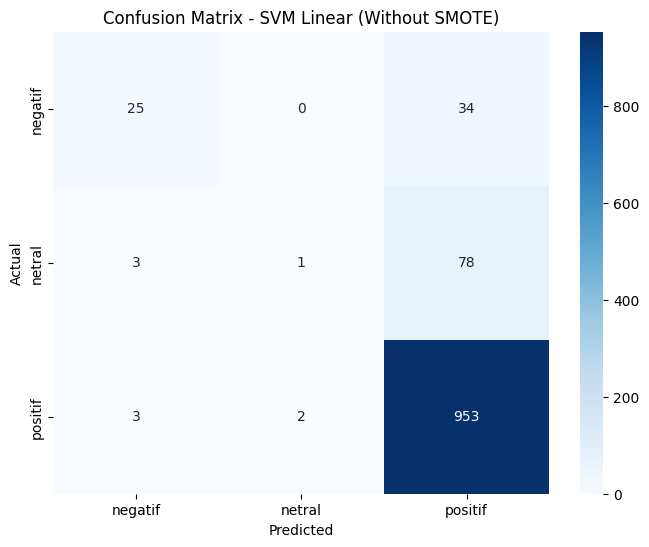

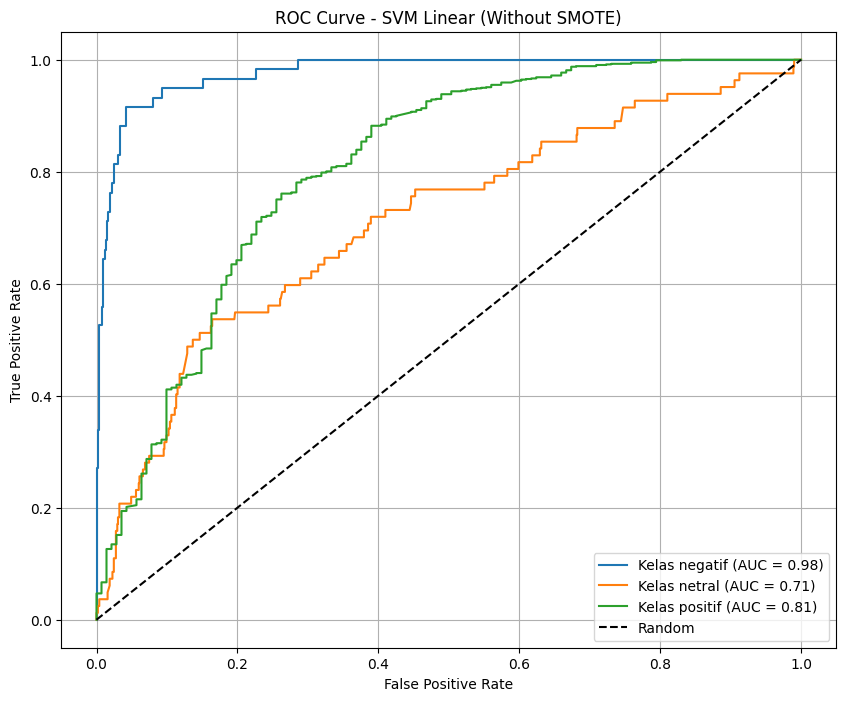

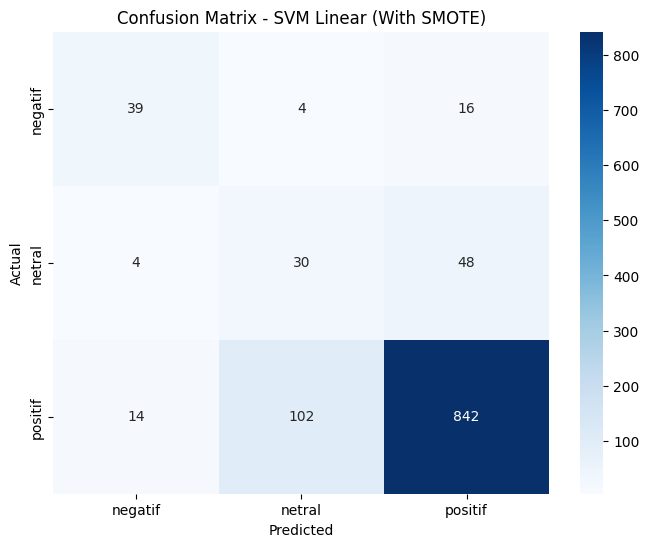

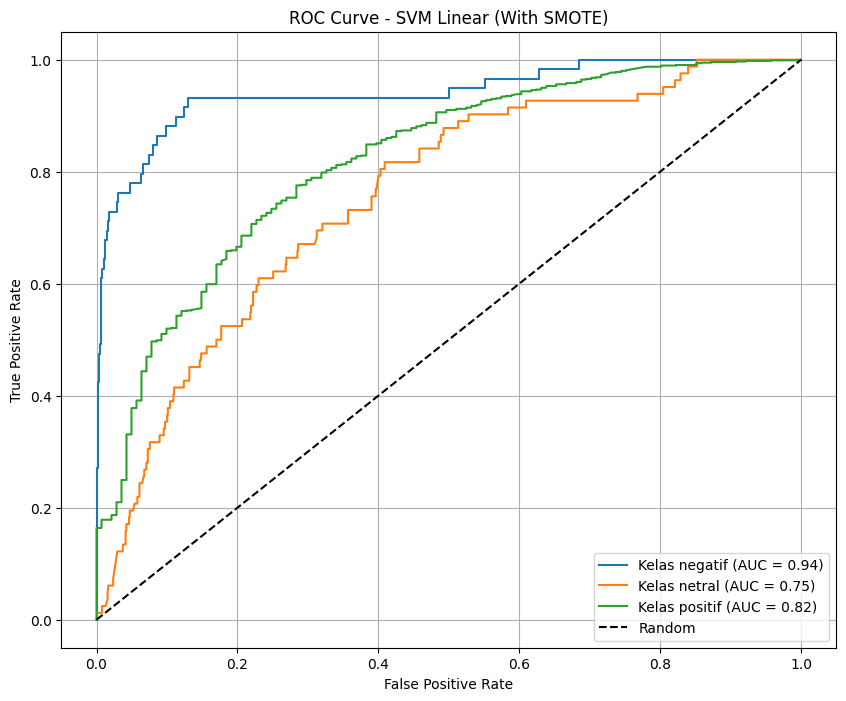

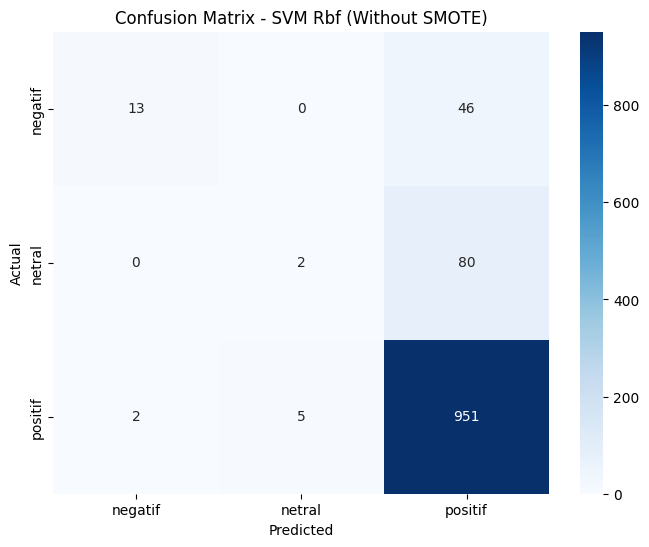

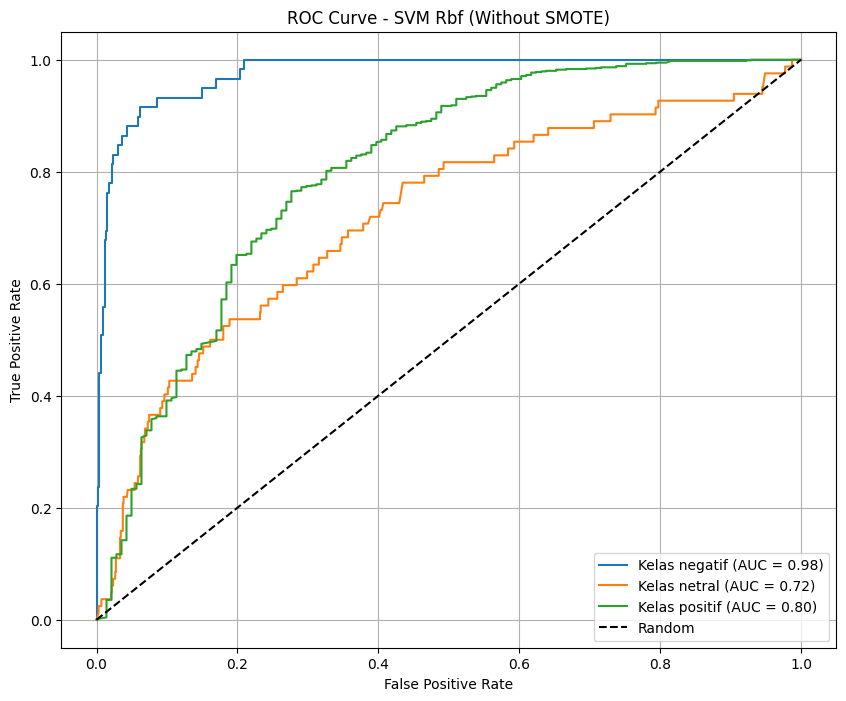

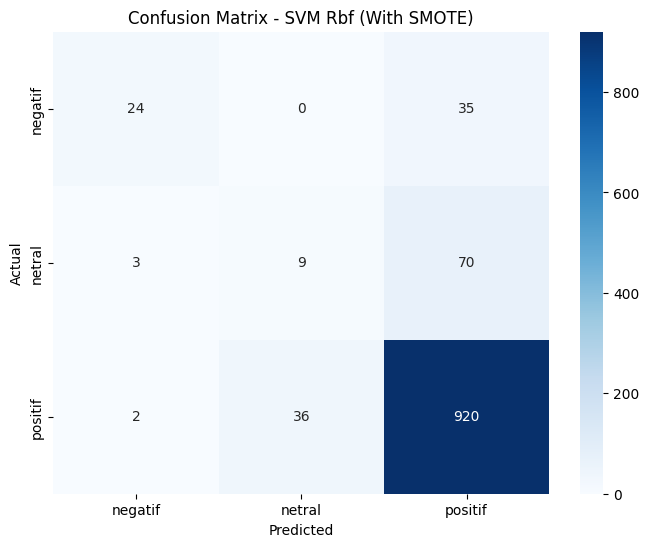

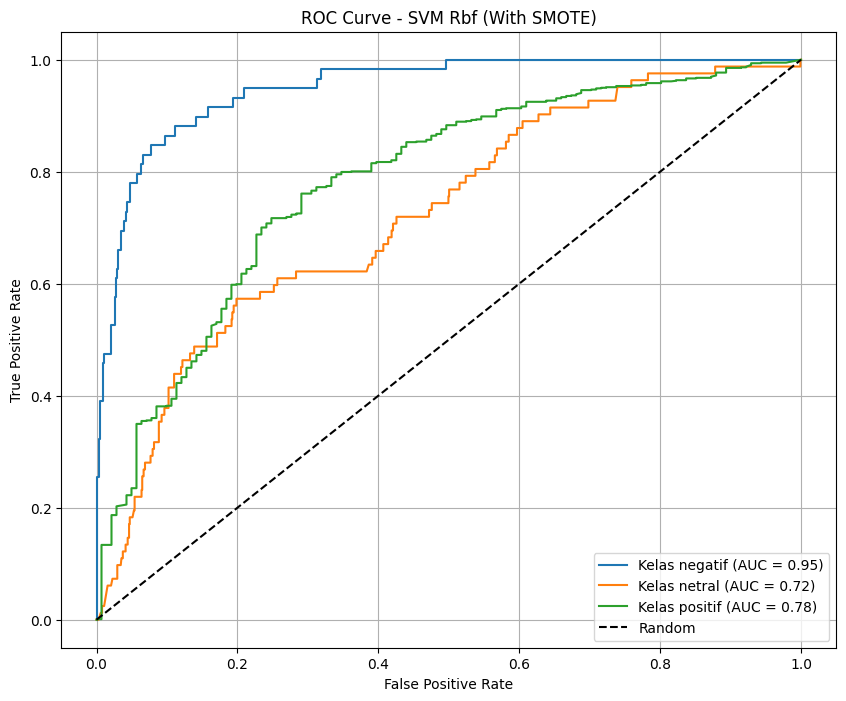

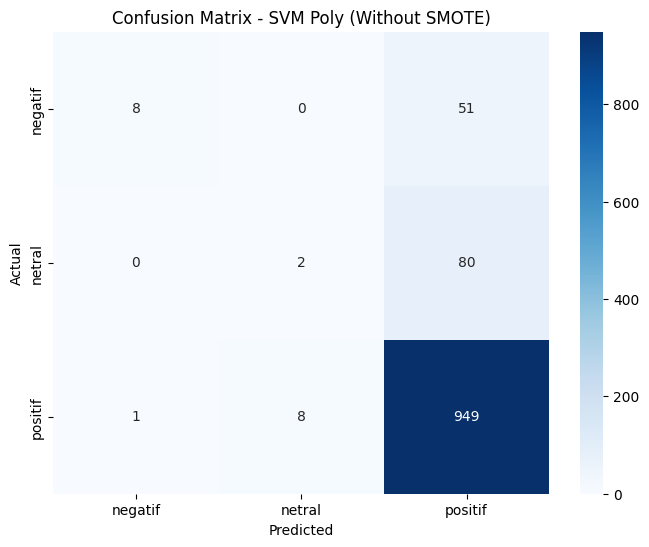

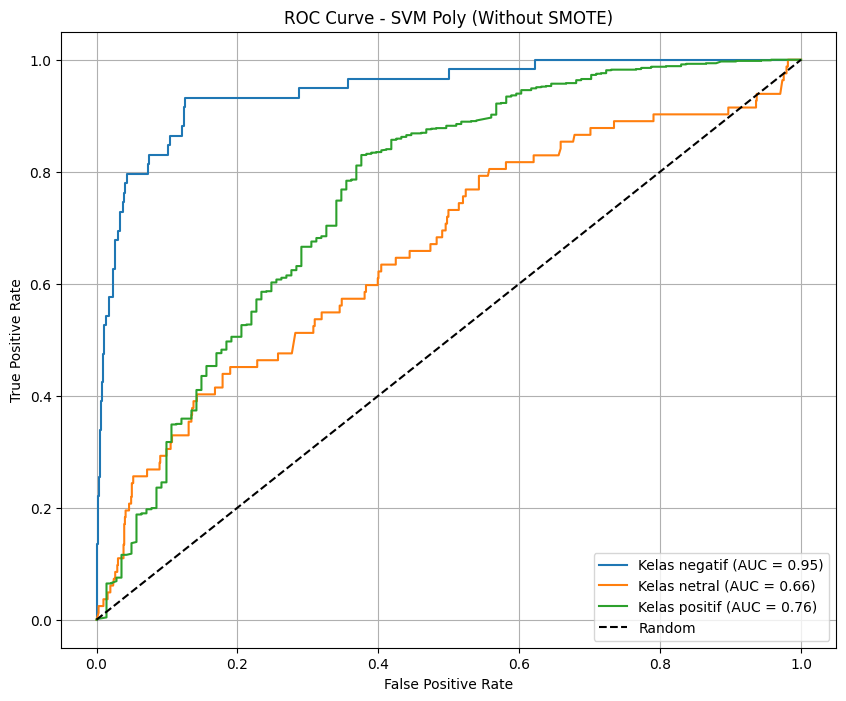

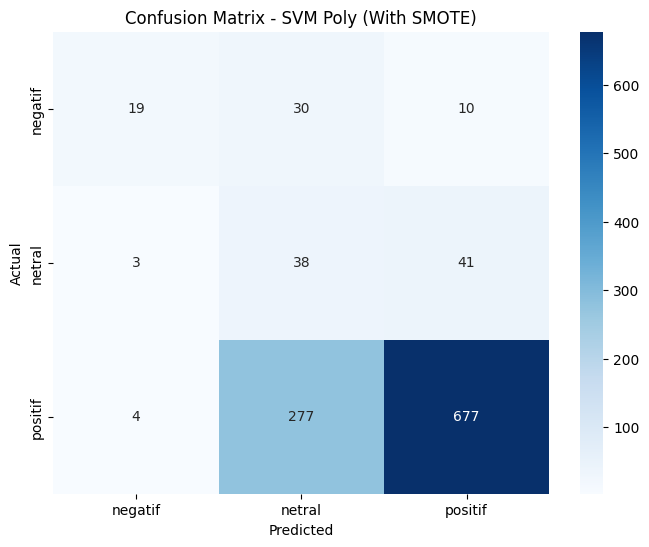

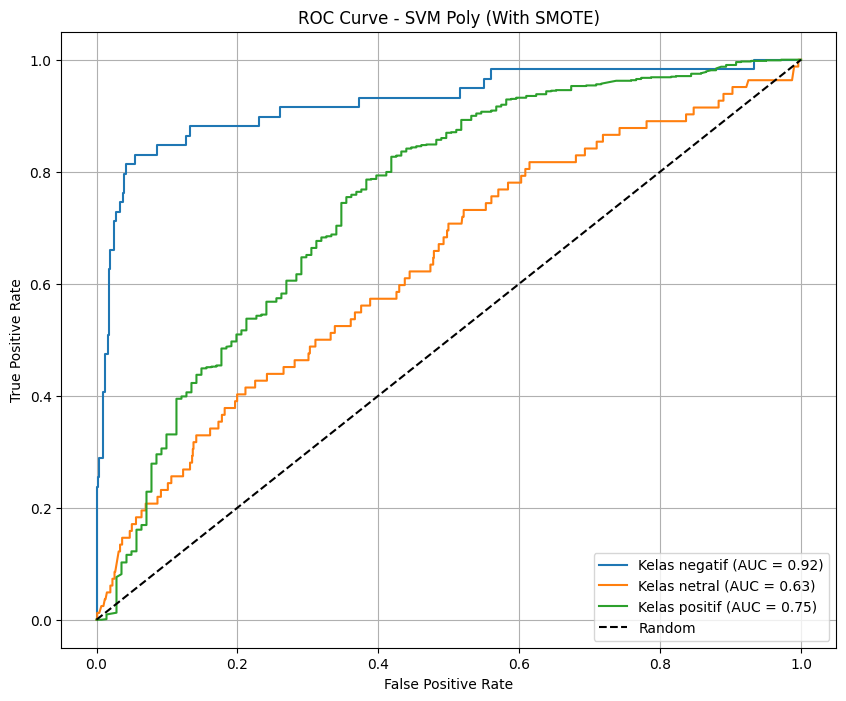

        Model          SMOTE   Accuracy  CV Accuracy  Precision     Recall  \
0  SVM Linear  Without SMOTE  89.080983    88.102713  84.819523  89.080983   
1  SVM Linear     With SMOTE  82.893540    91.097284  86.331517  82.893540   
2     SVM Rbf  Without SMOTE  87.898089    87.761286  83.756498  87.898089   
3     SVM Rbf     With SMOTE  86.715196    96.896544  84.175705  86.715196   
4    SVM Poly  Without SMOTE  87.261146    87.533806  82.861018  87.261146   
5    SVM Poly     With SMOTE  66.787989    77.021403  85.808429  66.787989   

    F1-score    ROC AUC                            Confusion Matrix  
0  85.286748  81.001152      [[25, 0, 34], [3, 1, 78], [3, 2, 953]]  
1  84.415877  82.100295  [[39, 4, 16], [4, 30, 48], [14, 102, 842]]  
2  83.694615  80.473696      [[13, 0, 46], [0, 2, 80], [2, 5, 951]]  
3  84.869850  78.584902     [[24, 0, 35], [3, 9, 70], [2, 36, 920]]  
4  82.769604  76.164780       [[8, 0, 51], [0, 2, 80], [1, 8, 949]]  
5  73.733030  74.926405  [[19, 30

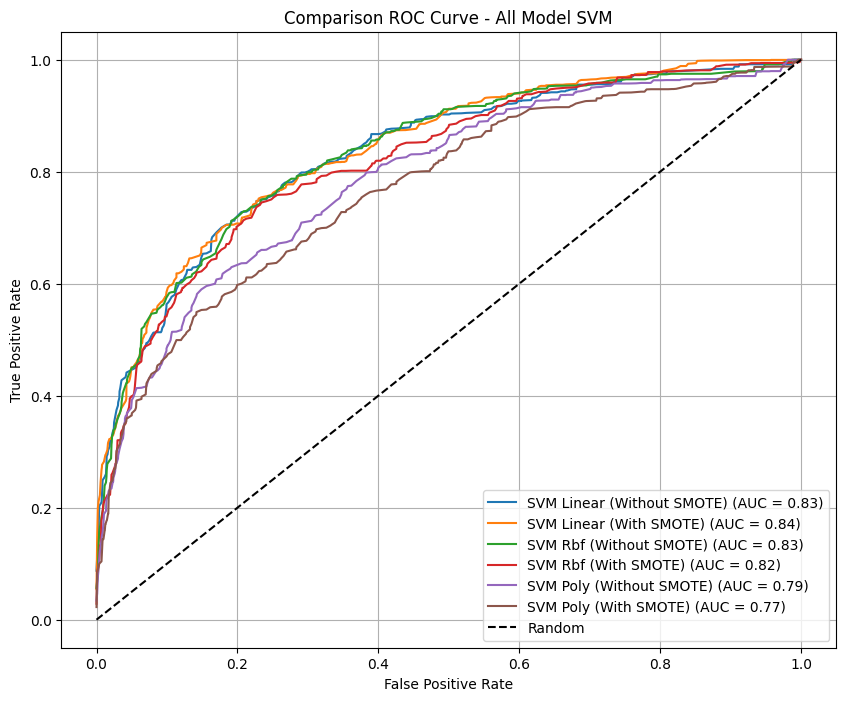

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# 2. Pisahkan fitur dan label
X = df['Review']
y = df['Sentiment']
classes = ['negatif', 'netral', 'positif']

# 3. Split data train/test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

# 5. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# 6. ROC Curve Multiclass per model
def plot_multiclass_roc(y_true, y_proba, classes, model_name, smote_used=False):
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = len(classes)

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Kelas {classes[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    smote_label = 'With SMOTE' if smote_used else 'Without SMOTE'
    plt.title(f'ROC Curve - {model_name} ({smote_label})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# 7. ROC Curve gabungan semua model
def plot_combined_roc(models_data, classes):
    plt.figure(figsize=(10, 8))
    for model_name, y_true, y_proba in models_data:
        y_true_bin = label_binarize(y_true, classes=classes)
        n_classes = len(classes)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        roc_auc_macro = auc(all_fpr, mean_tpr)

        plt.plot(all_fpr, mean_tpr, label=f'{model_name} (AUC = {roc_auc_macro:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.title('Comparison ROC Curve - All Model SVM')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# 8. Fungsi evaluasi
def train_evaluate_svm(X_train, y_train, kernel_type, smote_used=False):
    svm_model = SVC(kernel=kernel_type, probability=True)
    svm_model.fit(X_train, y_train)

    # Cross-validation
    cv_score = cross_val_score(svm_model, X_train, y_train, cv=10).mean() * 100

    # Prediksi
    y_pred = svm_model.predict(X_test_tfidf)
    y_proba = svm_model.predict_proba(X_test_tfidf)

    # Binarisasi label test
    y_test_bin = label_binarize(y_test, classes=classes)

    # Metrik
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    roc_auc = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class='ovr') * 100
    cm = confusion_matrix(y_test, y_pred)

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    smote_label = 'With SMOTE' if smote_used else 'Without SMOTE'
    plt.title(f'Confusion Matrix - SVM {kernel_type.capitalize()} ({smote_label})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve per kelas
    plot_multiclass_roc(y_test, y_proba, classes=classes,
                        model_name=f'SVM {kernel_type.capitalize()}', smote_used=smote_used)

    return acc, cv_score, prec, rec, f1, roc_auc, cm, y_proba

# 9. Evaluasi semua model
kernels = ['linear', 'rbf', 'poly']
results = []
roc_models_data = []

for kernel in kernels:
    # Tanpa SMOTE
    acc, cv, prec, rec, f1, roc_auc, cm, proba = train_evaluate_svm(X_train_tfidf, y_train, kernel, smote_used=False)
    results.append(['SVM ' + kernel.capitalize(), 'Without SMOTE', acc, cv, prec, rec, f1, roc_auc, cm])
    roc_models_data.append((f'SVM {kernel.capitalize()} (Without SMOTE)', y_test, proba))

    # Dengan SMOTE
    acc, cv, prec, rec, f1, roc_auc, cm, proba = train_evaluate_svm(X_train_smote, y_train_smote, kernel, smote_used=True)
    results.append(['SVM ' + kernel.capitalize(), 'With SMOTE', acc, cv, prec, rec, f1, roc_auc, cm])
    roc_models_data.append((f'SVM {kernel.capitalize()} (With SMOTE)', y_test, proba))

# 10. Rekap hasil
result_df = pd.DataFrame(results, columns=[
    'Model', 'SMOTE', 'Accuracy', 'CV Accuracy', 'Precision',
    'Recall', 'F1-score', 'ROC AUC', 'Confusion Matrix'
])
print(result_df)

# 11. Plot ROC gabungan semua model
plot_combined_roc(roc_models_data, classes)


Decision Tree dan Random Forest

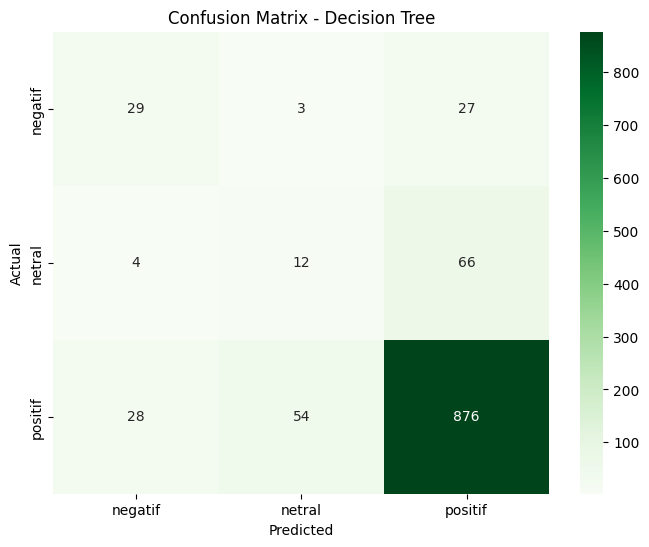

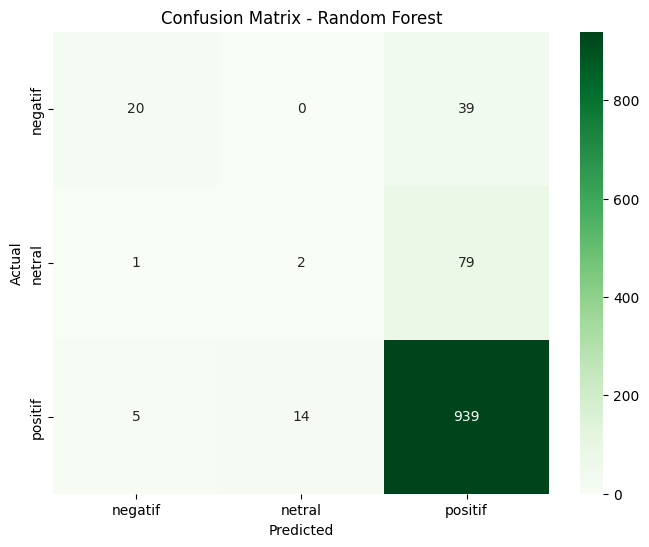

📊 Hasil Tanpa SMOTE:
            Model  Accuracy  Avg CV Accuracy  Precision    Recall   F1-score  \
0  Decision Tree  83.43949        85.008594  82.653847  83.43949  83.034510   
1  Random Forest  87.44313        87.647650  82.501060  87.44313  84.074354   

                           Confussion Matrix  
0  [[29, 3, 27], [4, 12, 66], [28, 54, 876]]  
1    [[20, 0, 39], [1, 2, 79], [5, 14, 939]]  


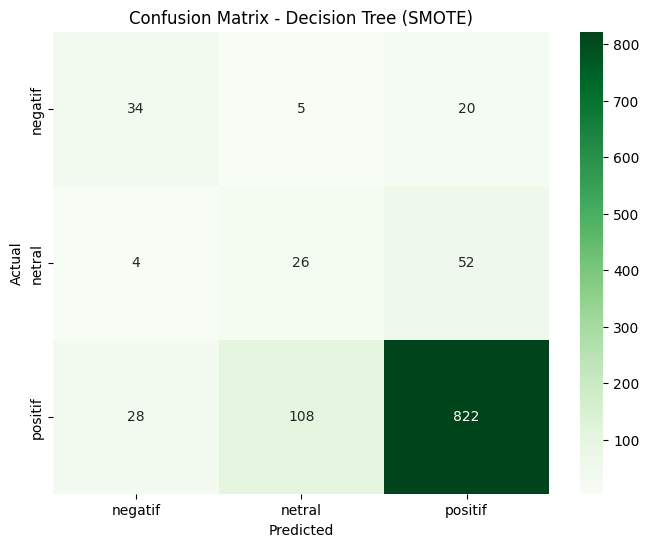

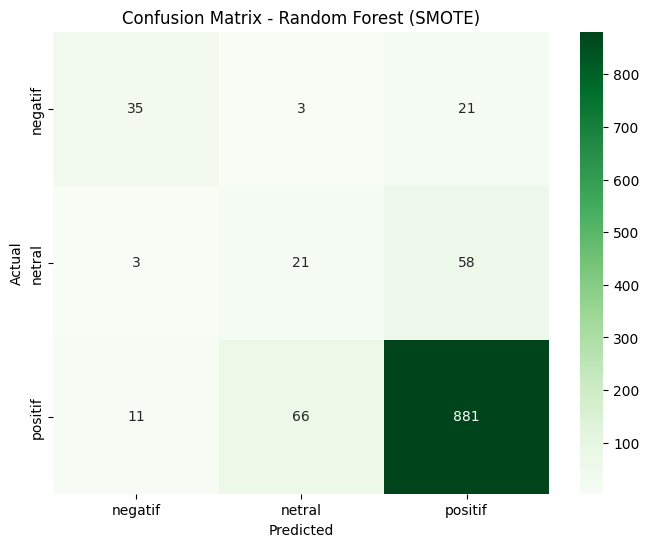


📊 Hasil Dengan SMOTE:
                    Model   Accuracy  Avg CV Accuracy  Precision     Recall  \
0  Decision Tree (SMOTE)  80.254777        92.227915  84.310983  80.254777   
1  Random Forest (SMOTE)  85.259327        95.453315  85.572409  85.259327   

    F1-score                           Confussion Matrix  
0  82.056066  [[34, 5, 20], [4, 26, 52], [28, 108, 822]]  
1  85.381741   [[35, 3, 21], [3, 21, 58], [11, 66, 881]]  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_excel('/content/drive/My Drive/Data Research/final_clean_text.xlsx')

# Fitur & Label
X = df['Review']
y = df['Sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Label untuk heatmap
labels = ['negatif', 'netral', 'positif']

# Fungsi pelatihan dan evaluasi
def train_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    cv_results = cross_val_score(model, X_train, y_train, cv=10)
    avg_accuracy = cv_results.mean() * 100
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1) * 100
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, avg_accuracy, precision, recall, f1, cm

# ---------------------------------------
# MODEL TANPA SMOTE
# ---------------------------------------
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

accuracy_dt, avg_accuracy_dt, precision_dt, recall_dt, f1_dt, cm_dt = train_evaluate_model(
    dt_model, "Decision Tree", X_train_tfidf, y_train, X_test_tfidf, y_test)

accuracy_rf, avg_accuracy_rf, precision_rf, recall_rf, f1_rf, cm_rf = train_evaluate_model(
    rf_model, "Random Forest", X_train_tfidf, y_train, X_test_tfidf, y_test)

result_no_smote = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Accuracy': [accuracy_dt, accuracy_rf],
    'Avg CV Accuracy': [avg_accuracy_dt, avg_accuracy_rf],
    'Precision': [precision_dt, precision_rf],
    'Recall': [recall_dt, recall_rf],
    'F1-score': [f1_dt, f1_rf],
    'Confussion Matrix': [cm_dt, cm_rf]
})

print("📊 Hasil Tanpa SMOTE:\n", result_no_smote)

# ---------------------------------------
# MODEL DENGAN SMOTE
# ---------------------------------------
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

accuracy_dt_s, avg_accuracy_dt_s, precision_dt_s, recall_dt_s, f1_dt_s, cm_dt_s = train_evaluate_model(
    dt_model, "Decision Tree (SMOTE)", X_train_smote, y_train_smote, X_test_tfidf, y_test)

accuracy_rf_s, avg_accuracy_rf_s, precision_rf_s, recall_rf_s, f1_rf_s, cm_rf_s = train_evaluate_model(
    rf_model, "Random Forest (SMOTE)", X_train_smote, y_train_smote, X_test_tfidf, y_test)

result_smote = pd.DataFrame({
    'Model': ['Decision Tree (SMOTE)', 'Random Forest (SMOTE)'],
    'Accuracy': [accuracy_dt_s, accuracy_rf_s],
    'Avg CV Accuracy': [avg_accuracy_dt_s, avg_accuracy_rf_s],
    'Precision': [precision_dt_s, precision_rf_s],
    'Recall': [recall_dt_s, recall_rf_s],
    'F1-score': [f1_dt_s, f1_rf_s],
    'Confussion Matrix': [cm_dt_s, cm_rf_s]
})

print("\n📊 Hasil Dengan SMOTE:\n", result_smote)


In [ ]:
import datasets
import numpy as np
import transformers

import shap
dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit into the pipeline model
short_data = [v[:500] for v in dataset["text"][:20]]
classifier = transformers.pipeline("sentiment-analysis", return_all_scores=True)
classifier(short_data[:2])
# define the explainer
explainer = shap.Explainer(classifier)
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:2])
shap.plots.text(shap_values[:, :, "POSITIVE"])
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=False)
pmodel(short_data[:2])
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
pmodel(short_data[:2])
explainer2 = shap.Explainer(pmodel)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:, :, 1])
explainer2 = shap.Explainer(pmodel, classifier.tokenizer)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:, :, 1])
masker = shap.maskers.Text(classifier.tokenizer)
explainer2 = shap.Explainer(pmodel, masker)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:, :, 1])
masker.shape("I like this movie.")
model_args = masker(np.array([True, True, True, True, True, True, True]), "I like this movie.")
model_args
pmodel(*model_args)
model_args = masker(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args
pmodel(*model_args)
masker2 = shap.maskers.Text(classifier.tokenizer, mask_token="...", collapse_mask_token=True)
model_args2 = masker2(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args2
pmodel(*model_args2)
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:20])
shap.plots.bar(shap_values[0, :, "POSITIVE"])
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0))
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0), order=shap.Explanation.argsort)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [04:53, 146.92s/it]


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [04:51, 145.52s/it]


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [04:53, 146.78s/it]


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [05:03, 151.56s/it]


  0%|          | 0/498 [00:00<?, ?it/s]

KeyboardInterrupt: 